In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
tf.config.run_functions_eagerly(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
human = pd.read_csv('/content/drive/My Drive/Colab Notebooks/human_pros_AB.txt', sep = '\t')
print(len(human))
human.head()

8161


,Protein_A_id,Protein_B_id,Protein_A_sequence,Protein_B_sequence,Protein_A_idx,Protein_B_idx,Interaction
0,1747,1652,MLSKRGCHARIYADFPIRRLISQRSSLETLEDIEENAPLRRCRTLS...,MLEGDLVSKMLRAVLQSHKNGVALPRLQGEYRSLTGDWIPFKQLGF...,0,1696,1
1,2157,1453,MRKDRLLHLCLVLLLILLSASDSNSTEPQYMVLVPSLLHTEAPKKG...,MHYCVLSAFLILHLVTVALSLSTCSTLDMDQFMRKRIEAIRGQILS...,1,1167,1
2,144,1298,MAASETVRLRLQFDYPPPATPHCTAFWLLVDLNRCRVVTDLISLIR...,MGGLASGGDVEPGLPVEVRGSNGAFYKGFVKDVHEDSVTIFFENNW...,2,54,1
3,1921,1758,MPGDHRRIRGPEESQPPQLYAADEEEAPGTRDPTRLRPVYARAGLL...,MLSSTAMYSAPGRDLGMEPHRAAGPLQLRFSPYVFNGGTILAIAGE...,3,90,1
4,2590,480,MTEGARAADEVRVPLGAPPPGPAALVGASPESPGAPGREAERGSEL...,MANGGGGGGGSSGGGGGGGGSSLRMSSNIHANHLSLDASSSSSSSS...,4,697,1


In [ ]:
human.describe()

,Protein_A_id,Protein_B_id,Protein_A_idx,Protein_B_idx,Interaction
count,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000
mean,1439.550668,1410.656660,1211.721970,1663.534248,0.477760
std,818.978918,836.205611,898.955762,972.948608,0.499536
min,0.000000,0.000000,0.000000,2.000000,0.000000
25%,744.000000,686.000000,415.000000,741.000000,0.000000
50%,1396.000000,1415.000000,1013.000000,1822.000000,0.000000
75%,2207.000000,2114.000000,2159.000000,2676.000000,1.000000
max,2832.000000,2834.000000,2633.000000,2834.000000,1.000000


In [ ]:
num_of_protein_A = len(human['Protein_A_idx'].unique())
num_of_protein_B = len(human['Protein_B_idx'].unique())

In [ ]:
def compile_model(num_of_user, num_of_item, learning_rate = 0.001):
  VECTOR_DIMENSION = 8

  protein_A_input = keras.layers.Input((1,))
  protein_A_embedding = keras.layers.Embedding(num_of_protein_A, VECTOR_DIMENSION, input_length = 1, name = 'protein_A_embedding', embeddings_initializer = 'he_normal', embeddings_regularizer=regularizers.L2(1e-4))
  protein_A = protein_A_embedding(protein_A_input)
  protein_A = keras.layers.Reshape((VECTOR_DIMENSION, 1))(protein_A)
  
  protein_A_bias = keras.layers.Embedding(num_of_protein_A, 1, embeddings_initializer = 'he_normal', embeddings_regularizer = regularizers.L2(1e-4))
  protein_A_b = protein_A_bias(protein_A_input)
  protein_A_b = keras.layers.Reshape((1,))(protein_A_b)

  protein_B_input = keras.layers.Input((1,))
  protein_B_embedding = keras.layers.Embedding(num_of_protein_B, VECTOR_DIMENSION, input_length = 1, name = 'protein_B_embedding', embeddings_initializer = 'he_normal', embeddings_regularizer=regularizers.L2(1e-4))
  protein_B = protein_B_embedding(protein_B_input)
  protein_B = keras.layers.Reshape((VECTOR_DIMENSION, 1))(protein_B)
  
  protein_B_b = protein_A_bias(protein_B_input)
  protein_B_b = keras.layers.Reshape((1,))(protein_B_b)

  dot_product = keras.layers.dot([protein_A, protein_B], axes = 1)
  output = keras.layers.Activation('sigmoid')(dot_product + protein_A_b + protein_B_b)


  model = keras.models.Model(inputs=[protein_A_input, protein_B_input], outputs = output)
  model.compile(
      loss = 'binary_crossentropy',
      optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
      metrics = ['binary_accuracy'],
  )
  return model

model = compile_model(num_of_protein_A, num_of_protein_B)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 protein_A_embedding (Embedding  (None, 1, 8)        15576       ['input_6[0][0]']                
 )                                                                                                
                                                                                                  
 protein_B_embedding (Embedding  (None, 1, 8)        14880       ['input_7[0][0]']          

In [ ]:
pa2idx = {v: k for k, v in dict(enumerate(human['Protein_A_idx'].unique())).items()}
pb2idx = {v: k for k, v in dict(enumerate(human['Protein_B_idx'].unique())).items()}

dataset = pd.DataFrame()
dataset['paidx'] = human['Protein_A_idx'].map(pa2idx.get)
dataset['pbidx'] = human['Protein_B_idx'].map(pb2idx.get)
dataset['y'] = human['Interaction']
dataset

,paidx,pbidx,y
0,0,0,1
1,1,1,1
2,2,2,1
3,3,3,1
4,4,4,1
...,...,...,...
8156,1831,1702,0
8157,170,112,0
8158,1789,1767,0
8159,1902,1670,0


In [ ]:
data_x = np.array([
                   dataset['paidx'].values, 
                   dataset['pbidx'].values
]).T
data_y = np.array([
                   dataset['y'].values
]).T
print(data_x.shape, data_y.shape)
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size = 0.1)
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size = 0.5)
print(
    train_x.shape, train_y.shape, 
    valid_x.shape, valid_y.shape,
    test_x.shape, test_y.shape
)

(8161, 2) (8161, 1)
(7344, 2) (7344, 1) (408, 2) (408, 1) (409, 2) (409, 1)


In [ ]:
model = compile_model(num_of_protein_A, num_of_protein_B)
history = model.fit(
    x = (train_x[:,0,None], train_x[:,1,None]),
    y = train_y, 
    batch_size = 512, 
    epochs = 30, 
    verbose = 'auto', 
    validation_data = ((valid_x[:,0,None], valid_x[:,1,None]),valid_y),
    shuffle = True, 
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


15/15 [==============================] - 2s 123ms/step - loss: 0.6961 - binary_accuracy: 0.5021 - val_loss: 0.6950 - val_binary_accuracy: 0.5081
Epoch 2/30
15/15 [==============================] - 2s 109ms/step - loss: 0.6945 - binary_accuracy: 0.5126 - val_loss: 0.6940 - val_binary_accuracy: 0.5164
Epoch 3/30
15/15 [==============================] - 2s 122ms/step - loss: 0.6937 - binary_accuracy: 0.5187 - val_loss: 0.6932 - val_binary_accuracy: 0.5272
Epoch 4/30
15/15 [==============================] - 2s 107ms/step - loss: 0.6931 - binary_accuracy: 0.5230 - val_loss: 0.6927 - val_binary_accuracy: 0.5338
Epoch 5/30
15/15 [==============================] - 2s 108ms/step - loss: 0.6927 - binary_accuracy: 0.5244 - val_loss: 0.6924 - val_binary_accuracy: 0.5380
Epoch 6/30
15/15 [==============================] - 1s 86ms/step - loss: 0.6925 - binary_accuracy: 0.5237 - val_loss: 0.6921 - val_binary_accuracy: 0.5399
Epoch 7/30
15/15 [==============================] - 1s 100ms/step - loss: 0.

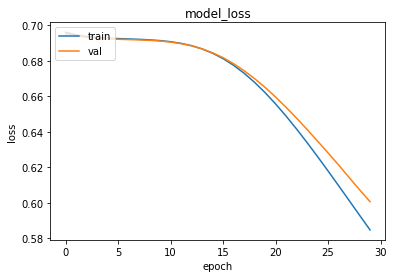

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc = 'upper left')
plt.show()

In [ ]:
model.evaluate(
    x = (test_x[:,0,None], test_x[:,1,None]),
    y = test_y
)

 9/13 [===================>..........] - ETA: 0s - loss: 0.6011 - binary_accuracy: 0.9896

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


13/13 [==============================] - 0s 16ms/step - loss: 0.6035 - binary_accuracy: 0.9846


[0.6035095453262329, 0.9846240878105164]

In [ ]:
pa_layer = model.layers[2]
pb_layer = model.layers[3]
pa_vectors = pa_layer.get_weights()[0]
pb_vectors = pb_layer.get_weights()[0]
pa_vectors.shape, pb_vectors.shape

((1947, 8), (1860, 8))

In [ ]:
source_df = (
    human
    .assign(
        paidx = lambda df: df['Protein_A_idx'].map(pb2idx.get)
    )
    .join(
        human
        .groupby('Protein_A_idx')
        .agg(count = ('Interaction', 'count'))
        .sort_values('count',ascending = False),
        on = 'Protein_A_idx',
        how = 'inner',
    )
)
print(len(source_df))
source_df.sort_values('count',ascending=False).head(15)

8161


,Protein_A_id,Protein_B_id,Protein_A_sequence,Protein_B_sequence,Protein_A_idx,Protein_B_idx,Interaction,paidx,count
4602,276,1387,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MGRVIRGQRKGAGSVFRAHVKHRKGAARLRAVDFAERHGYIKGIVK...,55,1265,0,312.0,44
2253,276,1222,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MFNKSFGTPFGGGTGGFGTTSTFGQNTGFGTTSGGAFGTSAFGSSN...,55,895,1,312.0,44
2312,276,1024,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MEHQLLCCEVETIRRAYPDANLLNDRVLRAMLKAEETCAPSVSYFK...,55,370,1,312.0,44
2666,276,865,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MDPSVTLWQFLLQLLREQGNGHIISWTSRDGGEFKLVDAEEVARLW...,55,77,1,312.0,44
2776,276,1963,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPKSKELVSSGSSGSDSDSEVDKKLKRKKQVAPEKPVKKQKTGETS...,55,888,1,312.0,44
2887,276,2475,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MSRRKQSKPRQIKRPLEDAIEDEEEECPSEETDIISKGDFPLEESF...,55,2353,1,312.0,44
3128,276,2469,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MSRQSTLYSFFPKSPALSDANKASARASREGGRAAAAPGASPSPGG...,55,1213,1,312.0,44
3601,276,1300,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MGGNMSVAFAAPRQRGKGEITPAAIQKMLDDNNHLIQCIMDSQNKG...,55,2463,1,312.0,44
4630,276,1664,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MLGLDACELGAQLLELLRLALCARVLLADKEGGPPAVDEVLDEAVP...,55,2656,0,312.0,44
5018,276,2722,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MVLAELYVSDREGSDATGDGTKEKPFKTGLKALMTVGKEPFPTIYV...,55,1359,0,312.0,44


In [ ]:
def cosine_similarity(v, mat, topn = 10):
  sim = np.dot(v, mat.T) / (np.linalg.norm(v) * np.linalg.norm(mat, axis = 1))
  ind = np.argpartition(sim, -(topn + 1))[-(topn+1):]
  ind = ind[np.argsort(sim[ind])][topn-1::-1]
  return sim[ind], ind

In [ ]:
sim, ind = cosine_similarity(pb_vectors[1], pb_vectors)
print(sim)
print(ind)
source_df[source_df['Protein_A_idx'].isin(ind)]

[0.9957128  0.9854381  0.98021066 0.9575961  0.8722179  0.8453154
 0.818081   0.7925819  0.78402233 0.7749728 ]
[ 603 1578  687  191  121  738  348  869   56 1047]


,Protein_A_id,Protein_B_id,Protein_A_sequence,Protein_B_sequence,Protein_A_idx,Protein_B_idx,Interaction,paidx,count
58,1841,1908,MNKLRQSFRRKKDVYVPEASRPHQWQTDEEGVRTGKCSFPVKYLGH...,MPAVSKGDGMRGLAVFISDIRNCKSKEAEIKRINKELANIRSKFKG...,56,1559,1,NaN,4
1207,1841,2754,MNKLRQSFRRKKDVYVPEASRPHQWQTDEEGVRTGKCSFPVKYLGH...,MVRSRQMCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKS...,56,959,1,NaN,4
2467,1841,2602,MNKLRQSFRRKKDVYVPEASRPHQWQTDEEGVRTGKCSFPVKYLGH...,MTGKATPPSLYSWRGVLFTCLPAARTRKRKEMSRQTATALPTGTSK...,56,462,1,NaN,4
2583,1841,1710,MNKLRQSFRRKKDVYVPEASRPHQWQTDEEGVRTGKCSFPVKYLGH...,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,56,1076,1,NaN,4
130,1577,734,MKPGFSPRGGGFGGRGGFGDRGGRGGRGGFGGGRGRGGGFRGRGRG...,MAVMEMACPGAPGSAVGQQKELPKAKEKTPPLGKKQSSVYKLEAVE...,121,574,1,1089.0,1
222,34,1341,MAAAPVAAGSGAGRGRRSAATVAAWGGWGGRPRPGNILLQLRQGQL...,MGLSTVPDLLLPLVLLELLVGIYPSGVIGLVPHLGDREKRDSVCPQ...,191,241,1,NaN,2
1440,34,2558,MAAAPVAAGSGAGRGRRSAATVAAWGGWGGRPRPGNILLQLRQGQL...,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,191,175,1,NaN,2
445,452,1660,MALSDEPAAGGPEEEAEDETLAFGAALEAFGESAETRALLGRLREV...,MLGARVAAHLDALGPLVPYVPPPLLPSMFYVGLFFVNVLILYYAFL...,348,936,1,339.0,1
841,2283,1885,MSDPEMGWVPEPPTMTLGASRVELRVSCHGLLDRDTLTKPHPCVLL...,MNTNDAKEYLARREIPQLFESLLNGLMCSKPEDPVEYLESCLQKVK...,603,1607,1,NaN,1
981,2634,1114,MTPLCPRPALCYHFLTSLLRSAMQNARGTAEGRSRGTLRARPAPRP...,MEQPQEEAPEVREEEEKEEVAEAEGAPELNGGPQHALPSSSYTDLS...,687,1127,1,1311.0,2
